In [31]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict

In [8]:
metadata_path = Path("/Users/conorhuh/Desktop/Berkeley/281/fp/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
data_folder_path_0 = Path("/Users/conorhuh/Desktop/Berkeley/281/fp/skin-cancer-mnist-ham10000/HAM10000_images_part_1")
data_folder_path_1 = Path("/Users/conorhuh/Desktop/Berkeley/281/fp/skin-cancer-mnist-ham10000/HAM10000_images_part_2")

In [11]:
data_dictionary = pd.read_csv(metadata_path.as_posix())
data_dictionary.head()

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


       lesion_id  image_id  dx_type   age   sex  localization
dx                                                           
akiec        327       327      327   327   327           327
bcc          514       514      514   514   514           514
bkl         1099      1099     1099  1089  1099          1099
df           115       115      115   115   115           115
mel         1113      1113     1113  1111  1113          1113
nv          6705      6705     6705  6660  6705          6705
vasc         142       142      142   142   142           142


<Axes: >

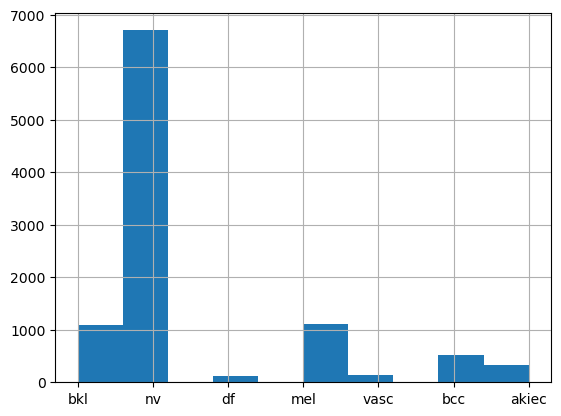

In [20]:
print(data_dictionary.groupby('dx').count())
class_labels = data_dictionary['dx']
class_labels.hist()

In [24]:
print(data_dictionary.groupby('dx').value_counts())

dx     lesion_id    image_id      dx_type    age   sex     localization   
akiec  HAM_0000005  ISIC_0024579  histo      75.0  female  lower extremity    1
                    ISIC_0025577  histo      75.0  female  lower extremity    1
                    ISIC_0029638  histo      75.0  female  lower extremity    1
                    ISIC_0030591  histo      75.0  female  lower extremity    1
       HAM_0000020  ISIC_0031922  histo      60.0  female  face               1
                                                                             ..
vasc   HAM_0007372  ISIC_0030283  consensus  55.0  male    trunk              1
       HAM_0007532  ISIC_0024662  consensus  75.0  male    trunk              1
       HAM_0007568  ISIC_0024867  consensus  75.0  male    trunk              1
       HAM_0007614  ISIC_0027672  histo      55.0  female  face               1
                    ISIC_0029514  histo      55.0  female  face               1
Name: count, Length: 9958, dtype: int64


In [35]:
test_image_path = Path("/Users/conorhuh/Desktop/Berkeley/281/fp/skin-cancer-mnist-ham10000/HAM10000_images_part_1/")


In [ ]:
# defaultdict(<class 'int'>, {(450, 600, 3): 10015})

# image_shapes = defaultdict(int)
# for img in test_image_path.iterdir():
#     temp_im = plt.imread(img.as_posix())
#     shape = (temp_im.shape)
#     image_shapes[shape] += 1

# test_image_path = Path("/Users/conorhuh/Desktop/Berkeley/281/fp/skin-cancer-mnist-ham10000/HAM10000_images_part_2/")
# for im in test_image_path.iterdir():
#     temp_im = plt.imread(img.as_posix())
#     shape = (temp_im.shape)
#     image_shapes[shape] += 1
# print(image_shapes)

defaultdict(<class 'int'>, {(450, 600, 3): 10015})


In [ ]:
# data augmentation
# we are going to want to flip along x, flip along y, rotate in 45 degree chunk 

# after data augmentation, we are going to want to test,train split, maybe validation
# 

In [ ]:
def train_and_evaluate_final_model(

model_name, X_train, y_train, X_test, y_test, label_encoder, random_state=42

):

"""

Trains the final model on all data and evaluates it on the test set.



Args:

model_name (str): The name of the winning model.

... other args are the data splits and configs.



Returns:

pd.DataFrame: The final classification report.

object: The trained final model object.

"""

print(f"\n================ Training Final '{model_name}' Model ================")


# Look up the winning model's configuration

config = MODELS[model_name]

estimator = config['model']

search_space = config['params']



# Oversample the entire training set

ros = RandomOverSampler(sampling_strategy='not majority', random_state=random_state)

X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)



# Search for optimal hyperparameters on the full, balanced training data

print("Searching for optimal hyperparameters...")

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

final_search = BayesSearchCV(

estimator=estimator,

search_spaces=search_space,

n_iter=50, # Using more iterations for the final model

cv=inner_cv,

scoring='f1_macro',

n_jobs=-1,

random_state=random_state,

verbose=0

).fit(X_train_bal, y_train_bal)



print(f"Final optimal parameters found: {final_search.best_params_}")


# The best estimator is the final, trained model

final_model = final_search.best_estimator_



# Evaluate the final model on the hold-out test set

print("\n================ Final Test Evaluation ================")

y_test_pred = final_model.predict(X_test)


report_dict = classification_report(

y_test, y_test_pred, target_names=label_encoder.classes_, output_dict=True

)

df_report_test = pd.DataFrame(report_dict).transpose().round(4)



return df_report_test, final_model